In [174]:
%matplotlib inline
import netCDF4
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import torch

In [237]:
file = '/Users/HP/Documents/GitHub/Machine-Learning-Cloud-Microphysics/Data/NetCDFFiles/ena19jan2023.nc'

In [214]:
data_folder = '/Users/HP/Documents/GitHub/Machine-Learning-Cloud-Microphysics/Data/NetCDFFiles/'

In [176]:
dataset = netCDF4.Dataset(file)
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: reference, Surface, ScalarAdvection, ScalarDiffusion, VelocityState, ScalarState, DiagnosticState, MicroBase, DiagnosticsTurbulence, DiagnosticsClouds, DiagnosticsCase, RRTMG


In [178]:
cloud_ds = xr.open_dataset(file, group = 'DiagnosticsClouds/profiles')
print("Dimensions: ", cloud_ds.dims)
print("Number of variables: ", len(cloud_ds.data_vars))
print("Variables: ", cloud_ds.data_vars)

Dimensions:  FrozenMappingWarningOnValuesAccess({'time': 721, 'z': 250, 'z_edge': 251})
Number of variables:  124
Variables:  Data variables:
    cloud_frac                   (time, z) float64 1MB ...
    core_frac                    (time, z) float64 1MB ...
    u_core                       (time, z) float64 1MB ...
    v_core                       (time, z) float64 1MB ...
    w_core                       (time, z) float64 1MB ...
    u_cloud                      (time, z) float64 1MB ...
    v_cloud                      (time, z) float64 1MB ...
    w_cloud                      (time, z) float64 1MB ...
    qv_cloud                     (time, z) float64 1MB ...
    qv_core                      (time, z) float64 1MB ...
    qc_cloud                     (time, z) float64 1MB ...
    qc_core                      (time, z) float64 1MB ...
    qr_cloud                     (time, z) float64 1MB ...
    qr_core                      (time, z) float64 1MB ...
    qnc_cloud                   

In [180]:
qc_autoconv_cloud = cloud_ds['qc_autoconv_cloud']
print(str(qc_autoconv_cloud) + '\n')
nc_autoconv_cloud = cloud_ds['nc_autoconv_cloud']
print(str(nc_autoconv_cloud) + '\n')
qr_autoconv_cloud = cloud_ds['qr_autoconv_cloud']
print(str(qr_autoconv_cloud) + '\n')
nr_autoconv_cloud = cloud_ds['nr_autoconv_cloud']
print(str(nr_autoconv_cloud) + '\n')
auto_cldmsink_b_cloud = cloud_ds['auto_cldmsink_b_cloud']
print(str(auto_cldmsink_b_cloud) + '\n')

<xarray.DataArray 'qc_autoconv_cloud' (time: 721, z: 250)> Size: 1MB
[180250 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04 4.32e+04
  * z        (z) float64 2kB 5.0 15.0 25.0 ... 2.475e+03 2.485e+03 2.495e+03
Attributes:
    long_name:      cloud water autoconversion mass cloud
    units:          kg kg^-1
    standard_name:  None_{cloud}

<xarray.DataArray 'nc_autoconv_cloud' (time: 721, z: 250)> Size: 1MB
[180250 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04 4.32e+04
  * z        (z) float64 2kB 5.0 15.0 25.0 ... 2.475e+03 2.485e+03 2.495e+03
Attributes:
    long_name:      cloud water autoconversion number cloud
    units:          kg^-1
    standard_name:  None_{cloud}

<xarray.DataArray 'qr_autoconv_cloud' (time: 721, z: 250)> Size: 1MB
[180250 values with dtype=float64]
Coordinates:
  * time     (time) float64 6kB 0.0 60.0 120.0 ... 4.308e+04 4.314e+04

In [188]:
THRESHOLD = 1e-6
def find_nonzero_threshold(dataset, num_values):
    index_list = []
    for i in range(dataset.shape[1]):
        array = dataset.isel(z = i).data
        count = np.count_nonzero(array >= THRESHOLD)
        if count > num_values:
            index_list.append(i)
    return index_list

In [189]:
def extract_data(dataset, index_list):
    data_list = []
    for index in index_list:
        data_list.append(dataset[:, index])
    data_array = np.array(data_list)
    return data_array

In [190]:
def data_profile(data):
    print(f"Mean: {np.mean(data)}")
    print(f"Variance: {np.var(data)}")
    print(f"Min: {np.min(data)}")
    print(f"Max: {np.max(data)}")

In [272]:
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [273]:
index_list = find_nonzero_threshold(qc_autoconv_cloud, 0.75 * qc_autoconv_cloud.shape[0])
print(len(index_list))
def prepare_dataset(dataset, log):
    dataset_copy = dataset.values
    if log:
        dataset_copy = np.log(dataset_copy, out = np.zeros_like(dataset_copy, dtype=np.float64), where = (dataset_copy > 0))
        # dataset_copy = np.log1p(dataset_copy)
        # dataset_copy = np.nan_to_num(dataset_copy, nan = 0)
    data = extract_data(dataset_copy, index_list)
    data = min_max_normalize(data)
    return data

63


In [278]:
# qc_autoconv_cloud_log = np.log(qc_autoconv_cloud_data, where = qc_autoconv_cloud_data > 0)
qc_autoconv_cloud_norm = prepare_dataset(qc_autoconv_cloud, False)
data_profile(qc_autoconv_cloud_norm)

Mean: 0.14722691424792264
Variance: 0.03097941076901359
Min: 0.0
Max: 1.0


(array([2.510e+03, 6.850e+02, 6.620e+02, 1.059e+03, 1.103e+03, 1.089e+03,
        1.294e+03, 1.360e+03, 1.296e+03, 1.287e+03, 1.188e+03, 1.210e+03,
        1.167e+03, 1.143e+03, 1.131e+03, 1.110e+03, 1.151e+03, 1.069e+03,
        1.043e+03, 9.990e+02, 9.640e+02, 9.710e+02, 9.900e+02, 9.750e+02,
        1.050e+03, 1.069e+03, 1.111e+03, 1.014e+03, 8.800e+02, 6.840e+02,
        5.250e+02, 4.510e+02, 4.970e+02, 5.220e+02, 5.180e+02, 4.890e+02,
        4.290e+02, 3.430e+02, 2.650e+02, 2.610e+02, 2.140e+02, 2.390e+02,
        1.560e+02, 1.600e+02, 1.680e+02, 1.800e+02, 1.170e+02, 1.260e+02,
        1.310e+02, 1.100e+02, 1.420e+02, 8.400e+01, 8.000e+01, 1.100e+02,
        1.040e+02, 1.210e+02, 9.900e+01, 7.400e+01, 7.700e+01, 7.900e+01,
        9.200e+01, 8.500e+01, 9.100e+01, 7.200e+01, 6.200e+01, 6.300e+01,
        7.300e+01, 7.300e+01, 7.400e+01, 6.000e+01, 5.900e+01, 6.000e+01,
        5.800e+01, 7.200e+01, 6.300e+01, 7.400e+01, 6.000e+01, 5.500e+01,
        5.300e+01, 5.600e+01, 6.100e+0

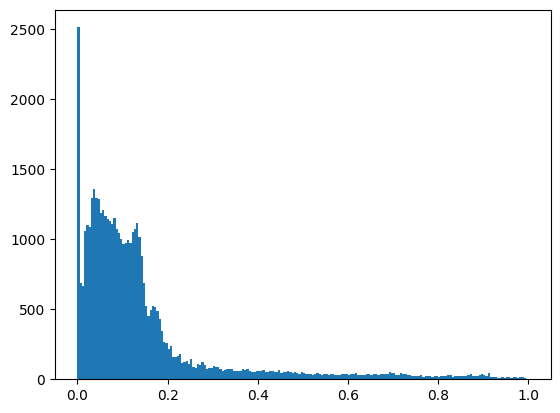

In [279]:
plt.hist(qc_autoconv_cloud_norm.flatten(), bins = 200)

In [250]:
print(nc_autoconv_cloud.values)

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [135.19825441 136.11279616 138.78879078 ...   0.           0.
    0.        ]
 [134.28325128 134.95469763 137.27742814 ...   0.           0.
    0.        ]
 [131.10188205 131.51498165 133.44464328 ...   0.           0.
    0.        ]]


In [251]:
nc_autoconv_cloud = cloud_ds['nc_autoconv_cloud']

In [252]:
data_profile(nc_autoconv_cloud.values)

Mean: 1300684.5928187678
Variance: 16746026928816.686
Min: 0.0
Max: 43301771.059108846


In [282]:
nc_autoconv_cloud_norm = prepare_dataset(nc_autoconv_cloud, False)
data_profile(nc_autoconv_cloud_norm)

Mean: 0.11261381254014076
Variance: 0.02615933363754023
Min: 0.0
Max: 1.0


(array([2.564e+03, 8.280e+02, 8.690e+02, 8.820e+02, 8.950e+02, 1.134e+03,
        1.392e+03, 2.506e+03, 2.633e+03, 2.542e+03, 2.469e+03, 1.904e+03,
        2.062e+03, 2.954e+03, 3.353e+03, 1.937e+03, 1.672e+03, 1.189e+03,
        9.760e+02, 6.620e+02, 5.050e+02, 3.670e+02, 3.330e+02, 2.810e+02,
        2.840e+02, 2.640e+02, 2.370e+02, 2.170e+02, 2.380e+02, 2.620e+02,
        2.320e+02, 1.570e+02, 1.400e+02, 1.360e+02, 1.360e+02, 1.250e+02,
        1.260e+02, 1.350e+02, 1.360e+02, 1.140e+02, 1.150e+02, 9.900e+01,
        1.040e+02, 9.700e+01, 7.300e+01, 8.400e+01, 7.600e+01, 6.600e+01,
        7.300e+01, 7.200e+01, 5.900e+01, 6.000e+01, 6.800e+01, 5.900e+01,
        4.800e+01, 7.100e+01, 5.400e+01, 4.700e+01, 6.900e+01, 4.500e+01,
        6.200e+01, 6.600e+01, 5.000e+01, 6.100e+01, 6.700e+01, 5.700e+01,
        6.900e+01, 8.500e+01, 9.000e+01, 9.600e+01, 8.400e+01, 8.200e+01,
        6.300e+01, 6.500e+01, 5.500e+01, 6.400e+01, 6.100e+01, 5.600e+01,
        5.800e+01, 2.700e+01, 2.300e+0

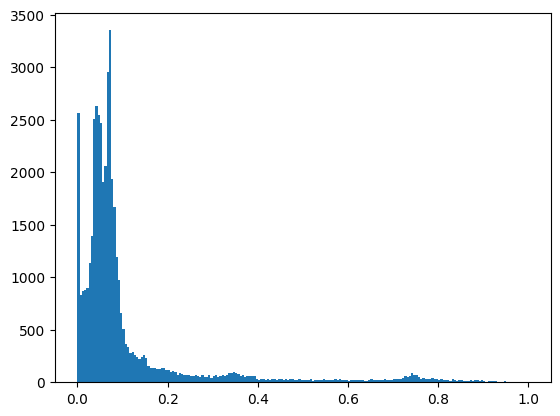

In [283]:
plt.hist(nc_autoconv_cloud_norm.flatten(), bins = 200)

log makes nc_autoconv distribution even more skewed so that's a no go


In [262]:
qr_autoconv_cloud_norm = prepare_dataset(qr_autoconv_cloud, True)
data_profile(qr_autoconv_cloud_norm)

Mean: 0.8414903491519746
Variance: 0.0033756614214912216
Min: 0.0
Max: 1.0


(array([2.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        3.0000e+00, 1.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 5.0000e+00, 3.0000e+00, 1.0000e+00, 6.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 8.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 6.0000e+00, 3.0000e+00, 5.0000e+00,
        1.1000e+01, 3.0000e+00, 3.0000e+00, 4.00

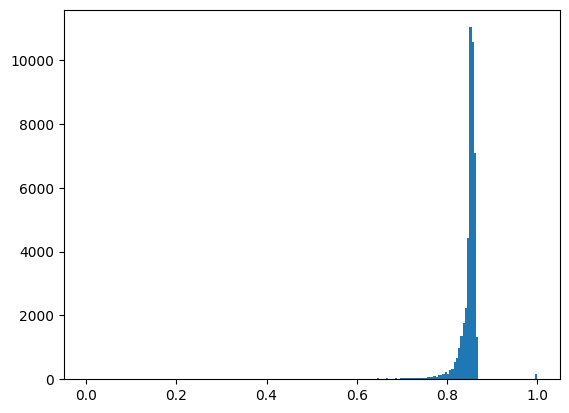

In [263]:
plt.hist(qr_autoconv_cloud_norm.flatten(), bins = 200, range = (0, 1))

Very responsive to log as well, better looking distribution

In [204]:
nr_autoconv_cloud_norm = prepare_dataset(nr_autoconv_cloud, True)
data_profile(nr_autoconv_cloud_norm)

Mean: 0.9670067164265979
Variance: 0.004275144945934681
Min: 0.0
Max: 1.0


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,   3.,   1.,   2.,
          2.,   2.,   3.,   5., 580., 110.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

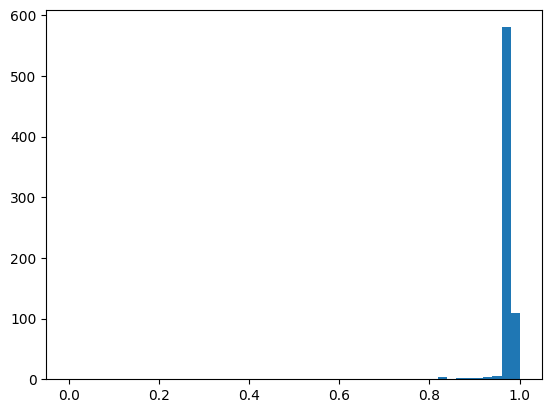

In [205]:
plt.hist(nr_autoconv_cloud_norm[10,:], bins = 50, range = (0, 1))

responsive to log

In [333]:
data_profile(auto_cldmsink_b_cloud.values)

Mean: 1.6418250353865698e-09
Variance: 2.1200079122283333e-17
Min: 0.0
Max: 4.2126917031596454e-08


In [334]:
auto_cldmsink_b_cloud_scale = auto_cldmsink_b_cloud
data_profile(auto_cldmsink_b_cloud_scale.values)

Mean: 1.6418250353865698e-09
Variance: 2.1200079122283333e-17
Min: 0.0
Max: 4.2126917031596454e-08


In [356]:
def standardize(data):
    return (data - np.mean(data)) / np.std(data)

def prepare_dataset(dataset, log):
    dataset_copy = dataset.values
    if log:
        dataset_copy = np.log(dataset_copy, out = np.zeros_like(dataset_copy, dtype=np.float64), where = (dataset_copy > 0))
    #     # dataset_copy = np.log1p(dataset_copy)
    # #     # dataset_copy = np.nan_to_num(dataset_copy, nan = 0)
    data = extract_data(dataset_copy, index_list) 
    # data = standardize(data)
    # quantile_transformer = QuantileTransformer(output_distribution='normal')

    robust_scaler = RobustScaler()
    data = robust_scaler.fit_transform(data)
    # data = quantile_transformer.fit_transform(data.transpose())
    return data 

In [357]:
auto_cldmsink_b_cloud_norm = prepare_dataset(auto_cldmsink_b_cloud, True)
data_profile(auto_cldmsink_b_cloud_norm)
print(np.min(auto_cldmsink_b_cloud_norm))
print(auto_cldmsink_b_cloud_norm.shape)

Mean: 0.10215443687059982
Variance: 1.7600911282894216
Min: -5.199337582605575
Max: 5.19933758270342
-5.199337582605575
(721, 63)


/Users/HP/Documents/GitHub/Machine-Learning-Cloud-Microphysics/CloudML/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (721). n_quantiles is set to n_samples.
  warnings.warn(


In [350]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

(array([  63.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   63.,    0.,    0.,
           0.,   63.,    0.,    0.,   63.,    0.,   63.,   63.,   63.,
           0.,   63.,  126.,   63.,   63.,  126.,  126.,  126.,  126.,
         189.,  126.,  189.,  252.,  189.,  252.,  252.,  315.,  315.,
         315.,  378.,  378.,  441.,  441.,  441.,  504.,  567.,  567.,
         567.,  630.,  630.,  693.,  756.,  693.,  756.,  819.,  819.,
         819.,  819.,  882.,  882.,  945.,  882.,  945.,  945.,  945.,
         945.,  882.,  945.,  945.,  945.,  882.,  945.,  882.,  882.,
         819.,  819.,  819.,  819.,  756.,  693.,  756.,  693.,  630.,
         630.,  567.,  567.,  561.,  481.,  420.,  415.,  411.,  337.,
      

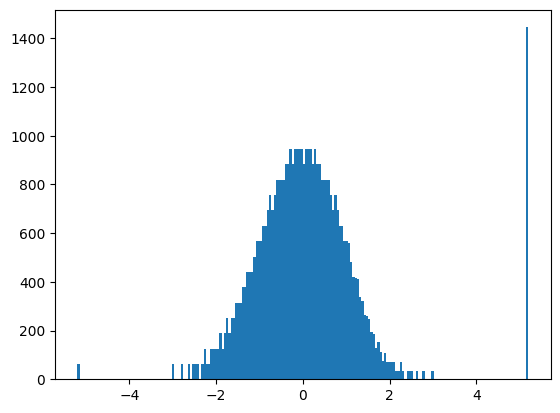

In [358]:
plt.hist(auto_cldmsink_b_cloud_norm.flatten(), bins = 200)

In [211]:
print(np.max(auto_cldmsink_b_cloud))

<xarray.DataArray 'auto_cldmsink_b_cloud' ()> Size: 8B
array(4.2126917e-08)


In [212]:
cloud_ds = xr.open_dataset('/Users/HP/Documents/GitHub/Machine-Learning-Cloud-Microphysics/Data/NetCDFFiles/ena19jan2023.nc', group = 'DiagnosticsClouds/profiles')


Much more responsive to log, nicer looking distribution
